# Preamble


**NOTE:** These are libraries that I've found useful for data analysis and Machine Learning.  Not all will necessarily be used during this exercise and this list would be curated, should this code ever need to be optimized for deployment/productionalization 


In [4]:
from pygeocoder import Geocoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from adspy_shared_utilities import plot_labelled_scatter
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import re
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib import cm 
%matplotlib inline


# Brainstorming and Exploration

The first task is to join the tables in a meaningful way, so before I can do that we need to take a look at the data dictionary, for hints.  From the given text file:

* **delivery_geography**
    * order_id: unique identifier per order (int)
    * latitude: delivery location (degrees)
    * longitude: delivery location (degrees)
    * estimateddeliverytime: an estimate of how long a delivery took (seconds)
    
* **delivery_prices**
    * order_id: unique identifier per order (int)
    * deliveredat: time delivered (timestamp)
    * totalprice: total product price (USD)

Since both files have the order_id column in common, we can start there as the key for the join.  However, this unmasks our first decision point: At this point, I have no idea (beyond intuition) how the data should be organized for the Machine Learning task that is ultimately the goal.   

As a result, it's difficult to know if I should perform a Left or Right join (which would return matches for both tables) or a full outer join (which would essentially just append the two tables together with null values in place for missing records).  A L/R join seems intuitive because of the table structures, but if I later want **ALL** of the records to be included in a ML analysis, I could impute values for the missing records.  

To move forward, I'll just perform all 3 join types (L,R, Full) and store them in separate data fames.


## Loading Data

In [5]:
geography = pd.read_csv('delivery_geography.csv')
prices = pd.read_csv('delivery_prices.csv')

In [6]:
geography.head()

,orderid,latitude,longitude,estimateddeliverytime
0,1552679,37.697073,-122.485903,259.0
1,1552697,37.782185,-122.454544,54.0
2,1552675,37.780840,-122.395820,228.0
3,1552934,37.783131,-122.388962,209.0
4,1552983,37.323786,-121.878904,345.0


In [7]:
prices.head()

,orderid,deliveredat,totalprice
0,1552553,2017-08-08T00:02:29.980+00:00,176.11
1,1552559,2017-08-08T00:09:06.077+00:00,71.03
2,1552499,2017-08-08T00:15:03.847+00:00,61.95
3,1552617,2017-08-08T00:16:40.820+00:00,62.40
4,1552632,2017-08-08T00:31:27.957+00:00,64.16


## 1. Joining Tables

As mentioned previously, there are a number of ways to join these tables. 

* We could complete an **inner join** which would provide us with a single combined table, where there is a match for orderid

* We could simply append the two together in an **outer join**

* We could determine that data from delivery_prices is relevant on its on but might be *enhanced* by data from delivery_geography and conduct a **right_join**

Let's go ahead and conduct all three, and then complete some basic exploratory analysis to determine which join to use, going forward.

In [8]:
##note the pd.merge function allows you to join on both left and right matches which produces the same output in this
##exercise as an inner join.

data_merge = pd.merge(geography, prices, left_on='orderid', right_on='orderid')
data_merge.sample(n=10)

,orderid,latitude,longitude,estimateddeliverytime,deliveredat,totalprice
634,1555849,37.642221,-122.434893,2.0,2017-08-08T21:43:10.347+00:00,73.00
2517,1554516,37.768533,-122.447082,242.0,2017-08-08T04:31:10.243+00:00,40.81
1012,1553231,32.797302,-117.253399,5.0,2017-08-08T01:51:58.517+00:00,49.95
1007,1552931,37.576229,-122.333806,2.0,2017-08-08T01:06:48.327+00:00,32.39
2194,1555452,37.433261,-122.128186,90.0,2017-08-08T19:33:15.133+00:00,32.24
1958,1556190,36.972029,-122.056035,191.0,2017-08-08T23:25:06.717+00:00,94.93
3103,1554479,32.744899,-117.210343,98.0,2017-08-08T04:36:55.953+00:00,102.19
258,1554520,37.581199,-122.369451,244.0,2017-08-08T04:29:01.977+00:00,61.01
2459,1555529,32.794921,-117.242919,170.0,2017-08-08T19:47:18.820+00:00,65.12
1800,1556084,37.734984,-122.134877,230.0,2017-08-08T23:04:48.933+00:00,117.06


In [9]:
data_right = pd.merge(geography,prices, on = 'orderid', how ='right')
data_right.sample(n=10)

,orderid,latitude,longitude,estimateddeliverytime,deliveredat,totalprice
1490,1553253,37.723613,-122.467317,109.0,2017-08-08T01:52:08.160+00:00,49.07
2480,1553101,33.887115,-118.375546,1.0,2017-08-08T01:26:13.077+00:00,60.69
831,1555986,36.969826,-121.902094,147.0,2017-08-08T23:37:22.497+00:00,122.55
1700,1555722,33.860491,-118.397684,207.0,2017-08-08T21:31:55.573+00:00,56.39
560,1553173,37.783141,-122.444213,203.0,2017-08-08T01:40:11.460+00:00,154.59
1168,1556122,37.526527,-122.349664,3.0,2017-08-08T23:11:16.043+00:00,40.82
2912,1553851,32.760731,-117.144925,190.0,2017-08-08T03:03:03.730+00:00,33.41
2623,1555313,34.008046,-118.490338,118.0,2017-08-08T18:26:34.190+00:00,88.00
2210,1556257,37.349604,-121.952716,146.0,2017-08-08T23:43:37.027+00:00,51.31
2820,1553044,32.758369,-117.145372,191.0,2017-08-08T01:36:43.397+00:00,41.68


In [10]:
dat_full = pd.merge(geography, prices, on ='orderid', how = 'outer')
data_full.sample(n=10)

,orderid,latitude,longitude,estimateddeliverytime,deliveredat,totalprice
1542,1553567,37.493378,-122.276848,46.0,2017-08-08T02:53:12.617+00:00,65.37
394,1554715,37.863273,-122.290610,48.0,2017-08-08T05:13:16.667+00:00,35.28
887,1553747,37.763424,-122.506884,288.0,2017-08-08T03:13:09.267+00:00,85.40
39,1554160,37.355196,-121.826572,145.0,2017-08-08T03:55:27.593+00:00,45.61
2044,1555234,37.561588,-122.294554,194.0,2017-08-08T18:08:28.270+00:00,42.46
1342,1552911,37.783779,-122.470599,140.0,2017-08-08T01:06:25.360+00:00,33.58
723,1556218,37.864417,-122.267863,258.0,2017-08-08T23:32:46.913+00:00,45.10
3794,1552478,NaN,NaN,NaN,2017-08-08T00:23:02.547+00:00,53.93
1778,1556032,37.779734,-122.469886,142.0,2017-08-08T23:03:28.250+00:00,92.33
3336,1553081,37.625153,-122.416151,122.0,2017-08-08T01:31:50.983+00:00,89.88


So, now we can see the three new DFs created from the joins we just did (inner, full outer, right) were done correctly because in our random sampled results you see null values for lat, long and delivery time where there was no order_id match in data_right and null values for either lat,long, delivery time *or* delivery date, total price for data_full.  

data_merge may have null values, but not for the same reason: they appeared naturally in the data.  Speaking of the data, this is a good time to start looking through it.

## 2. Adding in some External Data Sources

The current dataset has some valuable information, but it is also missing some that would be very useful for a business-oriented analysis:

* Order timestamps
* Human-readable Full addresses/zipcodes of orders
* Any demographic information at all about the purchaser

I chose to augment the dataset with zipcodes and SF neighborhood names in an attempt to make a future classification task more robust.

To do this, I utilized the Geocoder library which calls Google's maps API to perform reverse geocoding.  Then I matched resulting addresses to the data.

In [387]:
##set up geocoder
Data_Geocoder = Geocoder(api_key='MY API_KEY WOULD GO HERE')

In [391]:
#Add fully formatted address to each row.  This results in thousands of API calls, so it's pretty slow.
j = 0
for j in range(0,len(data_merge)):
    data_merge.set_value(j,'address', 
                         Data_Geocoder.reverse_geocode(eaze_merge['latitude'][j],eaze_merge['longitude'][j]).formatted_address)

In [13]:
#create a new DF to further upgrade.  The following line is commented out in order to save network/computational time
#I just save the results of the previous cell into a local csv

#data_merge_enhanced = data_merge

data_merge_enhanced = pd.read_csv('data_merge_enhanced.csv')

In [14]:
#extract Zipcodes
address = data_merge_enhanced['address']
i = 0
for i in range(0,len(data_merge_enhanced)):
    data_merge_enhanced.set_value(i,'zipcode', re.search('(\d{5})([- ])?(\d{4})?', address[i]).group(0) )

In [15]:
#create a SF neighborhoods database from here: http://www.healthysf.org/bdi/outcomes/index.html

sf_zipdata = [[94102, 'Hayes Valley/Tenderloin/North of Market'], [94103,'South of Market'],
             [94107,'Potrero Hill'],[94108,'Chinatown'],[94109, 'Polk/Russian Hill (Nob Hill)'], 
             [94110,'Inner Mission/Bernal Heights'], [94112, 'Ingelside-Excelsior/Crocker-Amazon'],
             [94114, 'Castro/Noe Valley'], [94115, 'Western Addition/Japantown'], [94116, 'Parkside/Forest Hill'],
             [94117,'Haight-Ashbury'], [94118, 'Inner Richmond' ], [94121, 'Outer Richmond' ], [94122, 'Sunset'],
             [94123, 'Marina'], [94124, 'Bayview-Hunters Point' ], [94127, 'St. Francis Wood/Miraloma/West Portal'],
             [94131, 'Twin Peaks-Glen Park'], [94132, 'Lake Merced' ], [94133, 'North Beach/Chinatown'], 
             [94134, 'Visitacion Valley/Sunnydale']]

sf_labels = ['zipcode', 'neighborhood']

In [16]:
sf_neighborhoods = pd.DataFrame.from_records(sf_zipdata, columns = sf_labels)

In [17]:
sf_neighborhoods['zipcode'] = sf_neighborhoods['zipcode'].astype(str)

In [18]:
sf_neighborhoods

,zipcode,neighborhood
0,94102,Hayes Valley/Tenderloin/North of Market
1,94103,South of Market
2,94107,Potrero Hill
3,94108,Chinatown
4,94109,Polk/Russian Hill (Nob Hill)
5,94110,Inner Mission/Bernal Heights
6,94112,Ingelside-Excelsior/Crocker-Amazon
7,94114,Castro/Noe Valley
8,94115,Western Addition/Japantown
9,94116,Parkside/Forest Hill


In [19]:
##perform left join data_merge, sf_neighborhoods on zipcode
data_merge_enhanced_neigh = pd.merge(eaze_merge_enhanced,sf_neighborhoods, how='left', on='zipcode')

In [21]:
##reduce the really annoying longform zipcode format (XXXXX-XXXX) to simple 5 digits (XXXXX)
for k in range(0,len(data_merge_enhanced)):
    data_merge_enhanced_neigh.set_value(k, 'zipcode' , data_merge_enhanced_neigh.zipcode[k][-5:])

In [22]:
data_merge_enhanced_neigh['zipcode'] = data_merge_enhanced_neigh['zipcode'].astype(int)

In [23]:
data_merge_enhanced_neigh.sample(n=5)

,Unnamed: 0,orderid,latitude,longitude,estimateddeliverytime,deliveredat,totalprice,address,zipcode,neighborhood
3178,3178,1555236,37.782489,-122.188599,216.0,2017-08-08T17:23:49.333+00:00,50.48,"18 Wyman Pl, Oakland, CA 94619, USA",94619,NaN
2607,2607,1554446,37.843048,-122.296374,199.0,2017-08-08T04:17:00.517+00:00,53.78,"6399 Christie Ave, Emeryville, CA 94608, USA",94608,NaN
879,879,1554703,37.780102,-122.405339,327.0,2017-08-08T04:54:59.317+00:00,63.31,"445 Tehama St, San Francisco, CA 94103, USA",94103,South of Market
3196,3196,1555966,37.679951,-122.404196,177.0,2017-08-08T22:41:38.120+00:00,86.79,"425 Sierra Point Rd, Brisbane, CA 94005, USA",94005,NaN
1706,1706,1555984,37.786067,-122.409252,55.0,2017-08-08T23:03:21.673+00:00,75.47,"222 Mason St, San Francisco, CA 94102, USA",94102,Hayes Valley/Tenderloin/North of Market


In [24]:


#Handle Dates, coerced into a new column with West Coast timezone and the appropriate format 

data_merge_enhanced_neigh['Date'] = pd.to_datetime(data_merge_enhanced_neigh['deliveredat'],
                                                                          errors='coerce')

data_merge_enhanced_neigh['Date'] = data_merge_enhanced_neigh['Date'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')


In [28]:
#As it turns out, the timestamp doesn't become relevant until the hour of purchase
data_merge_enhanced_neigh['year'] = data_merge_enhanced_neigh['Date'].dt.year
data_merge_enhanced_neigh['month'] = data_merge_enhanced_neigh['Date'].dt.month
data_merge_enhanced_neigh['day'] = data_merge_enhanced_neigh['Date'].dt.day
data_merge_enhanced_neigh['hour'] = data_merge_enhanced_neigh['Date'].dt.hour
data_merge_enhanced_neigh['minute'] = data_merge_enhanced_neigh['Date'].dt.minute

In [29]:
data_merge_enhanced_neigh.sample(n = 5)

,Unnamed: 0,orderid,latitude,longitude,estimateddeliverytime,deliveredat,totalprice,address,zipcode,neighborhood,Date,year,month,day,hour,minute
2719,2719,1556109,37.448893,-122.157598,82.0,2017-08-08T23:24:11.937+00:00,33.40,"530 Webster St, Palo Alto, CA 94301, USA",94301,NaN,2017-08-08 16:24:11.937000-07:00,2017,8,8,16,24
267,267,1554995,37.771020,-122.425347,11.0,2017-08-08T06:07:09.243+00:00,45.97,"55 Laguna St, San Francisco, CA 94102, USA",94102,Hayes Valley/Tenderloin/North of Market,2017-08-07 23:07:09.243000-07:00,2017,8,7,23,7
1407,1407,1553130,37.761087,-122.477205,222.0,2017-08-08T01:35:09.050+00:00,56.91,"1433 19th Ave, San Francisco, CA 94122, USA",94122,Sunset,2017-08-07 18:35:09.050000-07:00,2017,8,7,18,35
3257,3257,1555171,37.869797,-122.267582,117.0,2017-08-08T06:48:27.630+00:00,150.21,"2181 Shattuck Ave, Berkeley, CA 94704, USA",94704,NaN,2017-08-07 23:48:27.630000-07:00,2017,8,7,23,48
3219,3219,1553311,37.759240,-122.192043,1.0,2017-08-08T02:07:58.503+00:00,82.43,"1136 69th Ave, Oakland, CA 94621, USA",94621,NaN,2017-08-07 19:07:58.503000-07:00,2017,8,7,19,7


## 3. Peforming Join on a live Data Pipeline

Answering this question is a bit tough without knowning more about the  data architecture in question and specific supporting data platforms.  However, a fairly common solution to this type of data pipeline requirement includes the use of Apache Kafka to implement an automated streaming ETL process. 

The way that this could work at a high level, would be:

  * Run a Kafka source **connector** to read data from another system (RDMBS or NoSQL data platform) 
  * Modify the data in-flight (to save on computational cost and delay) using Single Message Transforms (SMTs) before
    writing it to a Kafka cluster
  * Process and enrich the data from a lightweight python/java application using the Kafka Streams API (e.g. if any  
    counts or sums are needed)
  * Run a Kafka sink connector to write data from the Kafka cluster to the data customer-facing system (e.g. Amazon S3 
    or GCS)
    
data stores and live applications could communicate with a Kafka cluster via the **Kafka Streams API**.  Depending on the how the data is to be utilized by the data application architecture, we may need to stream the data into a RESTful search engine like ElasticSearch which then would interface with data's application architecture via its own API.

Kafka is just one example, but many other technical solutions exist like Amazon Kinesis.


# Exploratory Data Analysis

## DataFrame 

In [30]:
datasets = {'data_merge' : data_merge_enhanced_neigh, 'data_right' : data_right, 'data full' : data_full}



for dataset in datasets:
   print( dataset, 'shape:', datasets[dataset].shape )
   print( datasets[dataset].isnull().sum())


eaze_merge shape: (3283, 16)
Unnamed: 0                  0
orderid                     0
latitude                    0
longitude                   0
estimateddeliverytime       0
deliveredat                 0
totalprice                  0
address                     0
zipcode                     0
neighborhood             2338
Date                        0
year                        0
month                       0
day                         0
hour                        0
minute                      0
dtype: int64
ease_right shape: (3352, 6)
orderid                   0
latitude                 69
longitude                69
estimateddeliverytime    69
deliveredat               0
totalprice                0
dtype: int64
eaze full shape: (3849, 6)
orderid                    0
latitude                  69
longitude                 69
estimateddeliverytime     70
deliveredat              497
totalprice               497
dtype: int64


At this point, seeing that the full join only produces 566 more unique records, and the right join even less, I feel fairly confident that utilizing the merged dataframe for further analysis is a least a good start. Also it's worth noting that the secondary join that was conducted to add SF "neighborhoods" was only somewhat successful, producing only ~950 complete records.  

So we'll continue by conducting some EDA on the **eaze_merge_enhanced_neigh** dataframe's contents specifically.

## data_merge EDA (Columns)

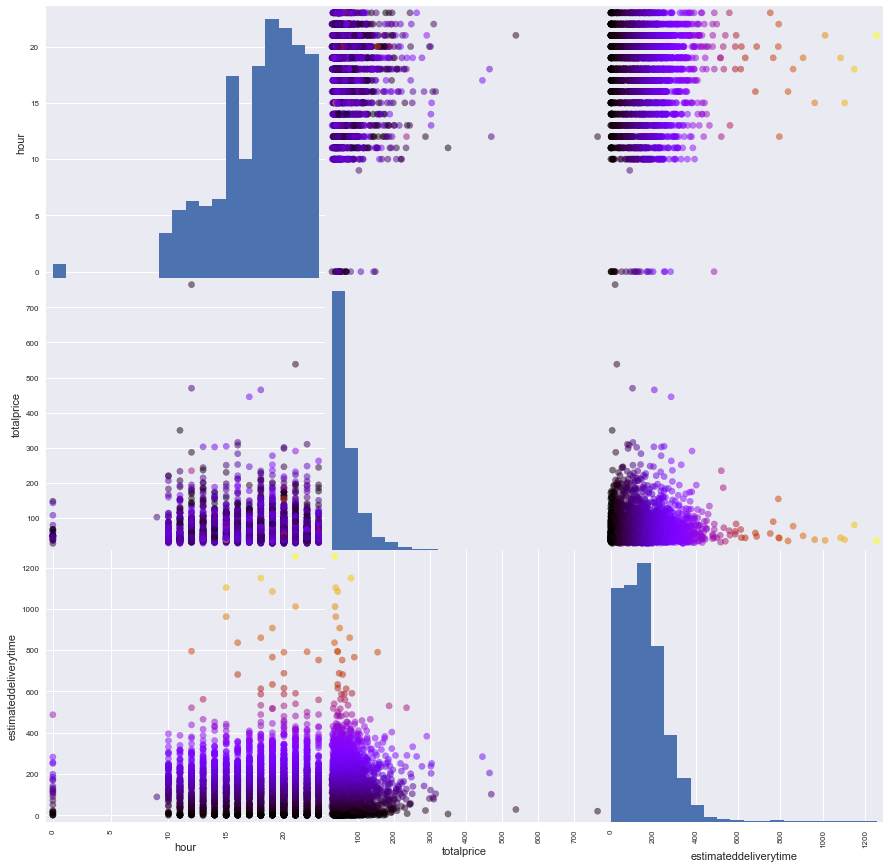

In [31]:

cmap = cm.get_cmap('gnuplot')
scatter = pd.scatter_matrix(data_merge_enhanced_neigh[['hour','totalprice', 'estimateddeliverytime'
                                       ]], c = data_merge_enhanced_neigh['estimateddeliverytime'], marker = 'o', s=40, hist_kwds={'bins':20}, figsize=(15,15), cmap=cmap)

This basic bivarate scatter/histogram plot tells me a lot about what the dataset is actually **missing**, and a few hypothesis about what might be useful to explore with ML.   

For starters, the latitude/longtitude fields were pretty much useless in thier unprocess form, and since the zip codes, and neighborhood locations are all string types, I can't use this plot to evaluatie.  That said, there are some interesting things to look at. 

First, for some reason it appears that some of the lowest price orders are taking the longest to deliver--which can't be good from a business standpoint.  

Also, most of the orders seem to be happening in a fairly narrow window of time in the late afternoon-evening, which is important for a delivery service using vehicles, since that is rush-hour. See the following histogram for a deeper look.


In [1]:
data_merge_enhanced_neigh.hist(column = 'hour', bins=15)

NameError: name 'data_merge_enhanced_neigh' is not defined

Unfortunately since all of the data is sampled from the same day, I can't compare the weekday effects, but it might be interesting to explore.

## 4. Machine Learning

There are a lot of approaches that I could have taken here, since I know so little about the customers in this dataset, beyond their general location.  Most notably I could have attempted to train a NN to identify patterns and extract useful features to be used to train a supervised learning model.  For simplicity's (and time's) sake, I chose to move forward with two classic clustering approaches (k-means and agglomerative [hierarchical]).  

It was a tough choice because the work that was done previously to enhance the dataset (adding in zipcodes and neighborhoods) will not be useful in this type of analysis since kmeans handles continuous, not categorical inputs.  Given more time, I would certainly expand my process to include additional algorithms.

In [33]:
#take a look at the feature options for training a clustering algorithm
data_merge_enhanced_neigh.columns

Index(['Unnamed: 0', 'orderid', 'latitude', 'longitude',
       'estimateddeliverytime', 'deliveredat', 'totalprice', 'address',
       'zipcode', 'neighborhood', 'Date', 'year', 'month', 'day', 'hour',
       'minute'],
      dtype='object')

In [36]:
#Set up the training set 
clmns = ['estimateddeliverytime','totalprice', 'hour','zipcode']

In [38]:
#Ensure that the data is standardized properly as Kmeans is sensitive to scale
data_merge_enhanced_neigh_tr = eaze_merge_enhanced_neigh
data_merge_enhanced_neigh_tr_std = stats.zscore(eaze_merge_enhanced_neigh_tr[clmns])

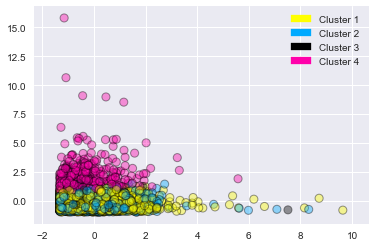

In [39]:
#Train the kmeans model, and plot a scatter plot showing cluster membership

kmeans = KMeans(n_clusters=4, random_state=0).fit(data_merge_enhanced_neigh_tr_std)

plot_labelled_scatter(eaze_merge_enhanced_neigh_tr_std, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])

#labels = kmeans.labels_

#data_merge_enhanced_neigh_tr['clusters'] = labels



Right away we can see that kmeans does a *decent* job of assigning observations to clusters.  However, cluster 1 and 3 are so tighly packed, it's difficult to visually draw any confidence.  So I tried another method: agglomerative.

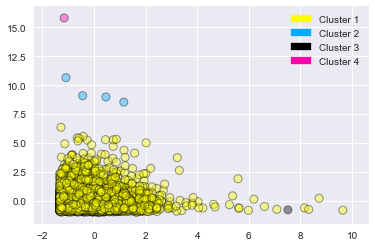

In [48]:
from sklearn.cluster import AgglomerativeClustering
from adspy_shared_utilities import plot_labelled_scatter

cls = AgglomerativeClustering(n_clusters = 4,linkage='average')

cls_assignment = cls.fit_predict(eaze_merge_enhanced_neigh_tr_std)


plot_labelled_scatter(data_merge_enhanced_neigh_tr_std, cls_assignment, 
                     ['Cluster 1', 'Cluster 2', 'Cluster 3','Cluster 4'])

labels = cls.labels_

data_merge_enhanced_neigh_tr['agg_clusters'] = labels



Much better.  This is worth carrying forward to try to develop some insight.  I'll add the cluster labels to the dataframe and then compute a matrix calculating the means for each cluster per feature.

In [49]:
clmns.extend(['agg_clusters'])

In [50]:
data_merge_enhanced_neigh_tr[clmns].groupby(['agg_clusters']).mean()

,estimateddeliverytime,totalprice,hour,zipcode
agg_clusters,,,,
0,152.013732,68.581449,17.779371,90691.540738
1,154.750000,479.282500,17.000000,94572.250000
2,1011.000000,36.180000,21.000000,2721.000000
3,20.000000,764.560000,12.000000,95003.000000


Some interesting points:

   * Clusters 1 and 3 have the highest average total price and most of the orders are on average around the noon and ~3:40 hours.  Right at lucnch and near quitting time.  That would be worth further analysis.  I would recommend labeling orders in these clusters as 'lunch' and 'happy hour' customers, respectively. Going forward you can use these class labels to predict using a supervized classification technique like Logistic Regression, Random Forest etc...
   * Cluster 3 also has the lowest average delivery time.  Additional data should be collected, analyzed to determine why these orders have an advantage, and to see if it can be applied globally
   * Conversely, cluster 0 has the highest average estimated delivery time, and some of the lowest prices of orders (as expected from the above EDA).
   
   

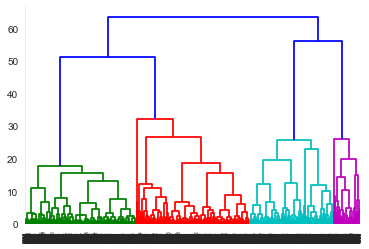

In [29]:
from scipy.cluster.hierarchy import ward, dendrogram
plt.figure()
dendrogram(ward(data_merge_enhanced_neigh_tr_std))
plt.show()

This dendrogram gives us a window into the potential # of other clusters that I might want to tune the models for.  Again, anything uncovered is a potential label to be used in future modeling efforts. 

## 5. Conclusion

Let's wrap up by exporting the final dataset.

In [56]:
data_classes = data_merge_enhanced_neigh_tr[['orderid','agg_clusters','hour','minute','zipcode','neighborhood','estimateddeliverytime',
                                             'totalprice']]

In [57]:
data_classes.head()

,orderid,agg_clusters,hour,minute,zipcode,neighborhood,estimateddeliverytime,totalprice
0,1552679,0,17,29,94015,NaN,259.0,48.36
1,1552697,0,17,26,94118,Inner Richmond,54.0,46.86
2,1552675,0,17,42,94107,Potrero Hill,228.0,64.39
3,1552934,0,18,13,94107,Potrero Hill,209.0,81.51
4,1552983,0,18,14,95112,NaN,345.0,74.80


In [58]:
data_classes.to_csv('eaze_solution.csv', encoding='utf-8')

There's ultimately a lot more that I would like to do with this data, but I ran out of time.  Most notably:

* Continue to iterate on clustering techniques to see if I can tighten the group--as I mentioned, Nueral Nets might be a good option with more data.
* Create a prediction engine to classify lunch, happy hour, expensive, and cheap order types
* Find a way to fill out the neighborhood column and provide a predictive "smart" heatmap view of what neighborhoods are likely to have dense order populations at a certain time

I would likely be recommending a few model-enabled products or features as a result of the analysis.

* Enhanced, Walmart-style transportation capacity optimization.  Use the predictive smart neighborhood heatmap to recommend loadout of  delivery cars dynamically with the optimal product mix
* Support marketing with targeted promotion recommendations and deep customer learning (assuming additional demographic information on customers at POS

I have some other ideas which require a better understanding/recommendations to the data collection pipeline.  I'd love to share them with you in person!

### Justin D. Norman
